In [2]:
import json
from pathlib import Path

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pickle
import torch
from torch import nn
import numpy as np
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

/users/eleves-b/2021/timothee.vincon/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def flatten(list_of_list):
    return [item for sublist in list_of_list for item in sublist]

def make_predictions(X_test, clf):

    test_labels = {}
    for transcription_id in test_set:
        with open(path_to_test / f"{transcription_id}.json", "r") as file:
            transcription = json.load(file)
        
        X_test = []
        for utterance in transcription:
            X_test.append(utterance["speaker"] + ": " + utterance["text"])
        
        X_test = bert.encode(X_test)

        y_test = clf.predict(X_test)
        test_labels[transcription_id] = y_test.tolist()

    with open("test_labels_text_baseline.json", "w") as file:
        json.dump(test_labels, file, indent=4)

In [4]:
path_to_test = Path("../data/test")

#####
# training and test sets of transcription ids
#####

test_set = ['ES2003', 'ES2004', 'ES2011', 'ES2014', 'IS1008', 'IS1009', 'TS3003', 'TS3004', 'TS3006', 'TS3007']
test_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in test_set])

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #if you have a GPU with CUDA installed, this may speed up computation

bert = SentenceTransformer('all-MiniLM-L6-v2')

# load variables from pickle file

X_training = pickle.load(open("../data/X_training.pkl", "rb"))
y_training = pickle.load(open("../data/y_training.pkl", "rb"))

print('data loaded')
print('shape of the data : ', X_training.shape)

data loaded
shape of the data :  (72623, 384)


In [6]:
# split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X_training, y_training, test_size=0.2, random_state=42)

print("split done")

split done


In [7]:
#we need to convert the data from Numpy arrays to Tensors
X_train = torch.from_numpy(X_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_train = torch.from_numpy(np.array(y_train)).float().to(device)
y_test = torch.from_numpy(np.array(y_test)).float().to(device)

In [41]:
n_hunits=512


model = nn.Sequential(
    nn.Linear(384, n_hunits),
    nn.ReLU(),
    nn.Linear(n_hunits, 2),
    nn.Softmax(dim=1)
)

epoch :  0 / 5000 loss :  0.4964085 train f1 :  0.0 test f1 :  0.0
epoch :  500 / 5000 loss :  0.45684588 train f1 :  0.5602689607435973 test f1 :  0.39042357274401474
epoch :  1000 / 5000 loss :  0.4506959 train f1 :  0.5882525267320933 test f1 :  0.3907618794796921
epoch :  1500 / 5000 loss :  0.44519377 train f1 :  0.6167793927183768 test f1 :  0.38120950323974084
epoch :  2000 / 5000 loss :  0.44002163 train f1 :  0.6410135199016734 test f1 :  0.36823303105248695
epoch :  2500 / 5000 loss :  0.43368822 train f1 :  0.6600152033447358 test f1 :  0.3802549498237049
epoch :  3000 / 5000 loss :  0.42857078 train f1 :  0.6791453961051239 test f1 :  0.3627829928216455
epoch :  3500 / 5000 loss :  0.42432037 train f1 :  0.6969312467691151 test f1 :  0.3446724768062974
epoch :  4000 / 5000 loss :  0.4158895 train f1 :  0.7174091413678266 test f1 :  0.3932167461579226
epoch :  4500 / 5000 loss :  0.41274875 train f1 :  0.7329518359561278 test f1 :  0.37340569877883306


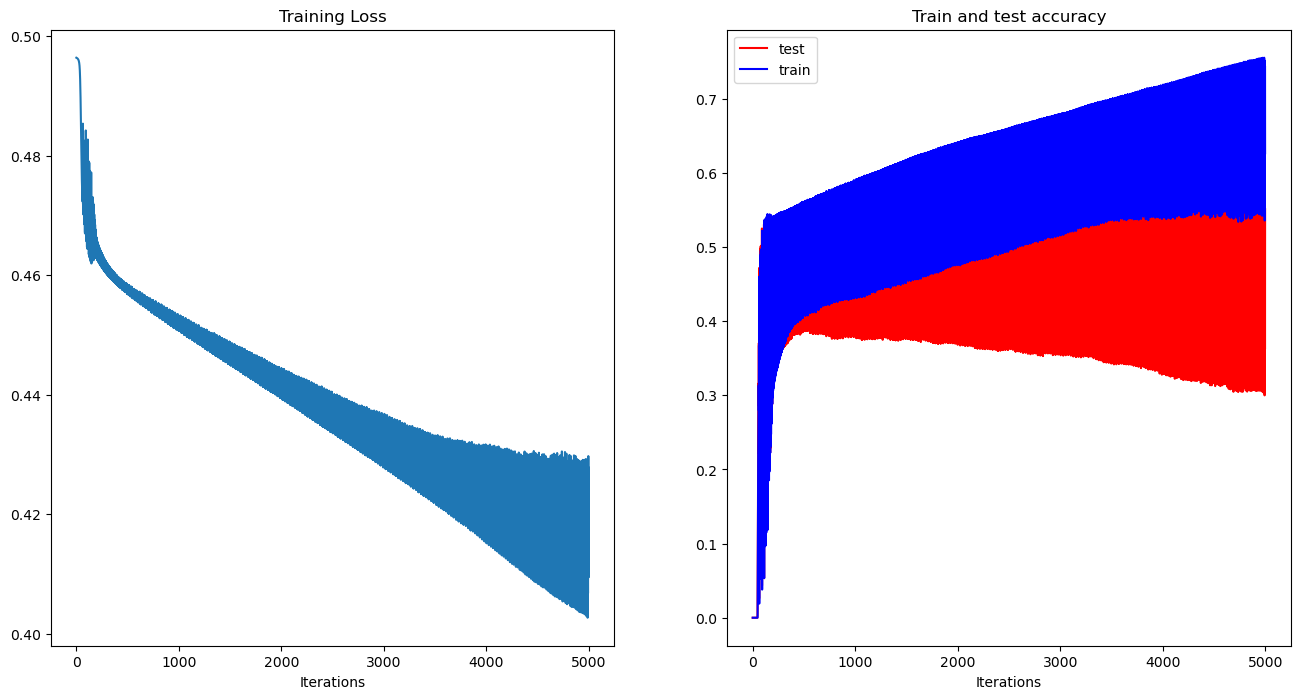

In [56]:
model.to(device) #if you have CUDA, this will make computation faster

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=10) #actually SGD is just GD in this case

#init performance measures
losses = []
tr_acc = []
test_acc = []

nb_epochs=5000

for epoch in range(nb_epochs):
    output=model.forward(X_train)
    loss = loss_function(output, y_train)
    optimizer.zero_grad() #required since pytorch accumulates the gradients
    loss.backward() #backpropagation step
    optimizer.step() #update the parameters
    
    #update loss and accuracy
    losses.append(loss.data.cpu().numpy())
    output_te=model(X_test)
    tr_acc.append(f1_score(y_train.cpu(), torch.max(output.cpu(), 1)[1]))
    test_acc.append(f1_score(y_test.cpu(), torch.max(output_te.cpu(), 1)[1]))
    if epoch % 500 == 0:
        print('epoch : ', epoch, '/', nb_epochs, 'loss : ', loss.data.cpu().numpy(), 'train f1 : ', tr_acc[-1], 'test f1 : ', test_acc[-1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.plot(losses)
ax1.set_title("Training Loss")
ax1.set_xlabel("Iterations")
ax2.plot(test_acc, c='r', label='test')
ax2.plot(tr_acc, c='b', label='train')
ax2.set_title("Train and test accuracy")
ax2.set_xlabel("Iterations")
plt.legend()
plt.show()

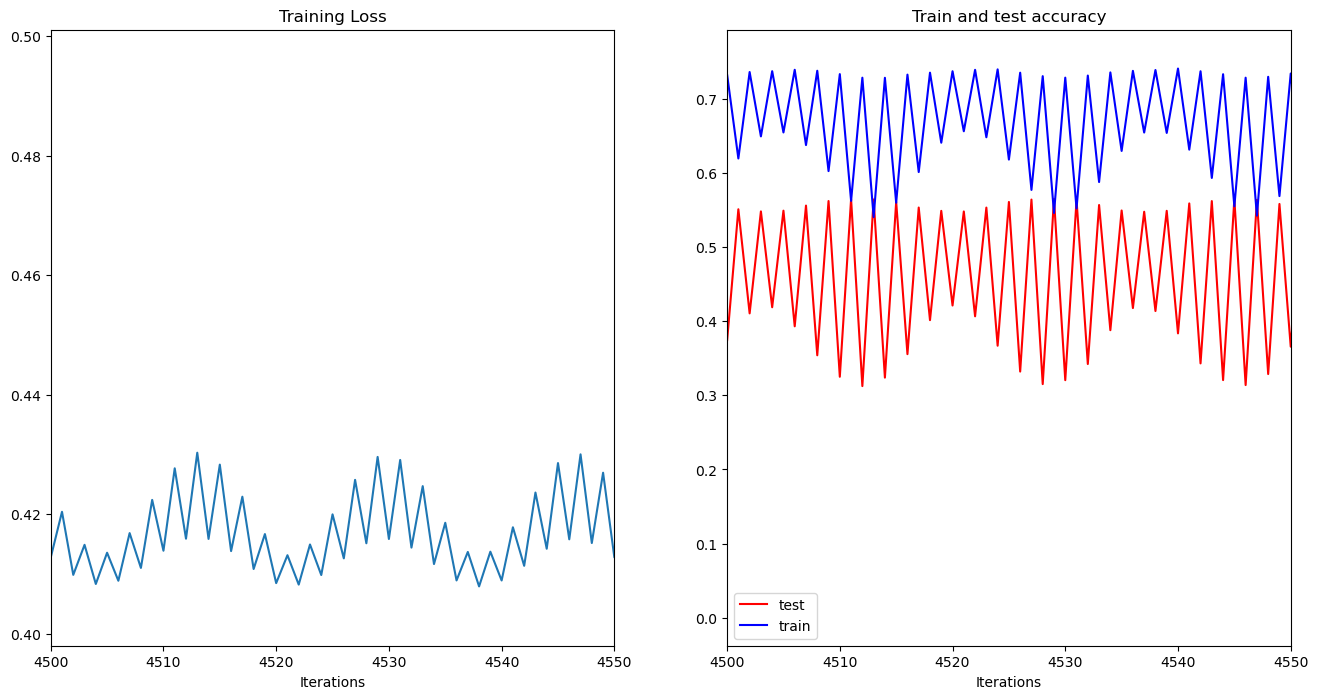

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.plot(losses)
ax1.set_title("Training Loss")
ax1.set_xlabel("Iterations")
ax1.set_xlim(4500, 4550)
ax2.plot(test_acc, c='r', label='test')
ax2.plot(tr_acc, c='b', label='train')
ax2.set_title("Train and test accuracy")
ax2.set_xlabel("Iterations")
ax2.set_xlim(4500, 4550)
plt.legend()
plt.show()

In [68]:
n_hunits=512


model = nn.Sequential(
    nn.Linear(384, n_hunits),
    nn.ReLU(),
    nn.Linear(n_hunits, n_hunits),
    nn.ReLU(),
    nn.Linear(n_hunits, 2),
    nn.Softmax(dim=1)
)

In [69]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

Sequential(
  (0): Linear(in_features=384, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=2, bias=True)
  (5): Softmax(dim=1)
)

epoch :  0 / 5000 loss :  0.7010906 train f1 :  0.31124802264590795 test f1 :  0.0 lr :  1
epoch :  500 / 5000 loss :  0.49654838 train f1 :  0.0 test f1 :  0.0 lr :  0.9
epoch :  1000 / 5000 loss :  0.47048548 train f1 :  0.33957452519965103 test f1 :  0.3536750745863846 lr :  0.81
epoch :  1500 / 5000 loss :  0.4587703 train f1 :  0.48048949434310784 test f1 :  0.46078431372549017 lr :  0.7290000000000001
epoch :  2000 / 5000 loss :  0.45541197 train f1 :  0.505316742081448 test f1 :  0.4713199723565999 lr :  0.6561000000000001
epoch :  2500 / 5000 loss :  0.45270625 train f1 :  0.5213153324743712 test f1 :  0.4838416021847975 lr :  0.5904900000000002
epoch :  3000 / 5000 loss :  0.45036018 train f1 :  0.5140828677839852 test f1 :  0.5073465859982714 lr :  0.5314410000000002
epoch :  3500 / 5000 loss :  0.44978768 train f1 :  0.47849094191620495 test f1 :  0.5363969093127288 lr :  0.47829690000000014
epoch :  4000 / 5000 loss :  0.44821286 train f1 :  0.47829369573423924 test f1 :  0

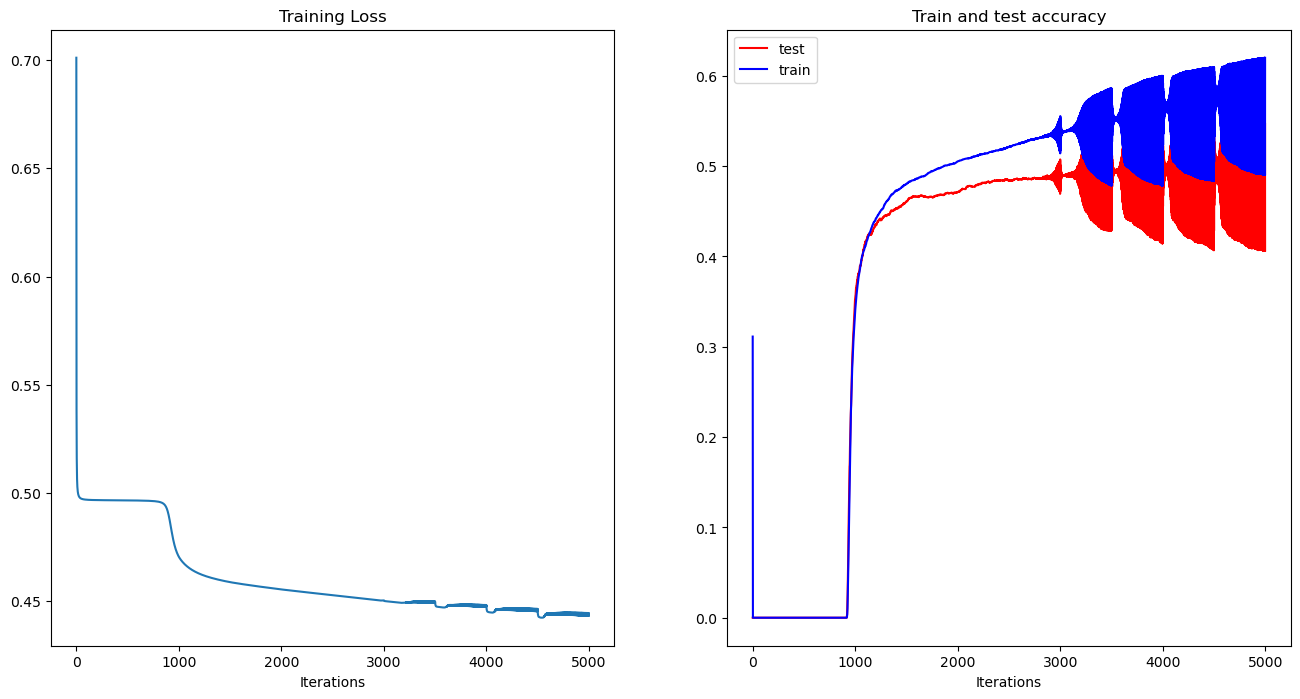

In [70]:
model.to(device) #if you have CUDA, this will make computation faster

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1) #actually SGD is just GD in this case

#init performance measures
losses = []
tr_acc = []
test_acc = []

nb_epochs=5000

for epoch in range(nb_epochs):
    output=model.forward(X_train)
    loss = loss_function(output, y_train)
    optimizer.zero_grad() #required since pytorch accumulates the gradients
    loss.backward() #backpropagation step
    optimizer.step() #update the parameters
    
    #update loss and accuracy
    losses.append(loss.data.cpu().numpy())
    output_te=model(X_test)
    tr_acc.append(f1_score(y_train.cpu(), torch.max(output.cpu(), 1)[1]))
    test_acc.append(f1_score(y_test.cpu(), torch.max(output_te.cpu(), 1)[1]))
    if epoch % 500 == 0:
        print('epoch : ', epoch, '/', nb_epochs, 'loss : ', loss.data.cpu().numpy(), 'train f1 : ', tr_acc[-1], 'test f1 : ', test_acc[-1], 'lr : ', optimizer.param_groups[0]['lr'])
        optimizer.param_groups[0]['lr'] *= 0.9

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
ax1.plot(losses)
ax1.set_title("Training Loss")
ax1.set_xlabel("Iterations")
ax2.plot(test_acc, c='r', label='test')
ax2.plot(tr_acc, c='b', label='train')
ax2.set_title("Train and test accuracy")
ax2.set_xlabel("Iterations")
plt.legend()
plt.show()

In [8]:
# define batch size
batch_size = 64

# create tensor datasets
trainset = TensorDataset(X_train, y_train)
testset = TensorDataset(X_test, y_test)

# create dataloaders
train_loader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(testset, shuffle=True, batch_size=batch_size)

In [32]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 

        self.dropout = nn.Dropout(0.8)
        
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):

        # Linear function
        out = self.fc1(x)

        # Non-linearity
        out = torch.relu(out)

        out = self.dropout(out)

        # Take note here use a final sigmoid function so your loss should not go through sigmoid again as we are using BCE loss.
        out = self.fc2(out)
        out = torch.sigmoid(out)
        out = out.squeeze()
    
        return out

In [34]:
input_dim = 384
hidden_dim = 512
output_dim = 1

# Instantiate model class and assign to object
model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

# Push model to CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function (binary cross-entropy)
criterion = nn.BCELoss()

# Optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

In [35]:
# Number of groups of parameters
print('Number of groups of parameters {}'.format(len(list(model.parameters()))))
print('-'*50)
# Print parameters
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())
print('-'*50)

Number of groups of parameters 4
--------------------------------------------------
torch.Size([512, 384])
torch.Size([512])
torch.Size([1, 512])
torch.Size([1])
--------------------------------------------------


In [55]:
def train_model(model, optizmizer, loss_criterion):
    iter = 0
    num_epochs = 10
    history_train_acc, history_val_acc, history_train_loss, history_val_loss = [], [], [], []
    best_f1_score = 0
    for epoch in range(num_epochs):
        for i, (samples, labels) in enumerate(train_loader):

            print(samples.shape, labels.shape)
            
            # Training mode
            model.train()

            # Load samples

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model(samples)

            print(outputs[0], labels[0])
            print(outputs.shape, labels.shape)

            # Calculate Loss: softmax --> cross entropy loss
            loss = loss_criterion(outputs, labels)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()

            iter += 1

            if iter % 100 == 0:
                # Get training statistics
                train_loss = loss.data.item()

                # Testing mode
                model.eval()
                # Calculate Accuracy         
                correct = 0
                total = 0
                true_positives = 0
                true_negatives = 0
                false_positives = 0
                false_negatives = 0
                # Iterate through test dataset
                for samples, labels in test_loader:
                    # Load samples

                    # Forward pass only to get logits/output
                    outputs = model(samples)

                    # Val loss
                    val_loss = criterion(outputs.view(-1, 1), labels.view(-1, 1))

                    predicted = outputs.ge(0.5).view(-1)

                    # Total number of labels
                    total += labels.size(0)

                    # Total correct predictions
                    correct += (predicted.type(torch.FloatTensor).cpu() == labels.type(torch.FloatTensor)).sum().item()

                    true_positives += ((predicted.type(torch.FloatTensor).cpu() == 1) & (labels.type(torch.FloatTensor) == 1)).sum().item()
                    true_negatives += ((predicted.type(torch.FloatTensor).cpu() == 0) & (labels.type(torch.FloatTensor) == 0)).sum().item()
                    false_positives += ((predicted.type(torch.FloatTensor).cpu() == 1) & (labels.type(torch.FloatTensor) == 0)).sum().item()
                    false_negatives += ((predicted.type(torch.FloatTensor).cpu() == 0) & (labels.type(torch.FloatTensor) == 1)).sum().item()


                f1_score = 2 * true_positives / (2 * true_positives + false_positives + false_negatives)

                # Print Loss
                print('Iter: {} | Train Loss: {} | Val Loss: {} | Val F1: {}'.format(iter, train_loss, val_loss.item(), round(f1_score, 4)))

                # Append to history
                history_val_loss.append(val_loss.data.item())
                history_val_acc.append(round(f1_score, 4))
                history_train_loss.append(train_loss)

                # Save model when accuracy beats best accuracy
                if f1_score > best_f1_score:
                    best_f1_score = f1_score
                    # We can load this best model on the validation set later
                    torch.save(model.state_dict(), 'best_model.pth')
    return (history_train_acc, history_val_acc, history_train_loss, history_val_loss)



In [29]:
def plot_losses(history_train_loss, history_val_loss):
    # Set plotting style
    #plt.style.use(('dark_background', 'bmh'))
    plt.style.use('bmh')
    plt.rc('axes', facecolor='none')
    plt.rc('figure', figsize=(16, 4))

    # Plotting loss graph
    plt.plot(history_train_loss, label='Train')
    plt.plot(history_val_loss, label='Test')
    plt.title('Loss Graph')
    plt.legend()
    plt.show()

In [36]:
(train_acc, val_acc, train_loss, val_loss) = train_model(model, optimizer, criterion)

Iter: 100 | Train Loss: 0.5229253768920898 | Val Loss: 0.2594502568244934 | Val F1: 0.3609
Iter: 200 | Train Loss: 0.26669377088546753 | Val Loss: 0.438904732465744 | Val F1: 0.3625
Iter: 300 | Train Loss: 0.3342883884906769 | Val Loss: 0.3981720805168152 | Val F1: 0.4167
Iter: 400 | Train Loss: 0.26119372248649597 | Val Loss: 0.3134427070617676 | Val F1: 0.4454
Iter: 500 | Train Loss: 0.2841683030128479 | Val Loss: 0.37632837891578674 | Val F1: 0.4249
Iter: 600 | Train Loss: 0.21152430772781372 | Val Loss: 0.304082989692688 | Val F1: 0.438
Iter: 700 | Train Loss: 0.3551740050315857 | Val Loss: 0.27019768953323364 | Val F1: 0.4733
Iter: 800 | Train Loss: 0.3260125517845154 | Val Loss: 0.24666140973567963 | Val F1: 0.4451
Iter: 900 | Train Loss: 0.39737725257873535 | Val Loss: 0.2761351764202118 | Val F1: 0.4595
Iter: 1000 | Train Loss: 0.25587356090545654 | Val Loss: 0.40971073508262634 | Val F1: 0.4008
Iter: 1100 | Train Loss: 0.3761213421821594 | Val Loss: 0.3619374632835388 | Val F1

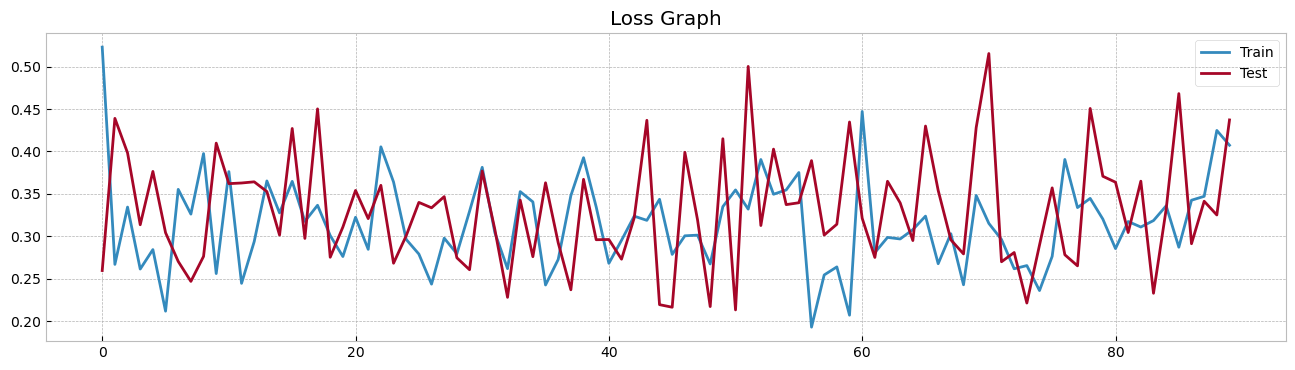

In [37]:
plot_losses(train_loss, val_loss)

In [66]:
# split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X_training, y_training, test_size=0.2, random_state=42)

print("split done")

split done


In [67]:
# define a KNN classifier

from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=3)

# fit the classifier to the training data

clf.fit(X_train, y_train)

# make predictions on the test data

y_pred = clf.predict(X_test)

# compute the f1 score

f1_score(y_test, y_pred)

0.41165838228648893

In [8]:
# define logistic regression classifier

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter=1500)

# fit the classifier to the training data

clf.fit(X_train, y_train)

# make predictions on the test data

y_pred = clf.predict(X_test)

# compute the f1 score

f1_score(y_test, y_pred)

0.4611045828437133

In [13]:
# define a random forest classifier

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=100, random_state=0)

# fit the classifier to the training data

clf.fit(X_train, y_train)

# make predictions on the test data

y_pred = clf.predict(X_test)

# compute the f1 score

f1_score(y_test, y_pred)

0.28681481481481486

In [12]:
# define naive bayes classifier

from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()

# fit the classifier to the training data

clf.fit(X_train, y_train)

# make predictions on the test data

y_pred = clf.predict(X_test)

# compute the f1 score

f1_score(y_test, y_pred)

0.5244455336355839